<a href="https://colab.research.google.com/github/Ariiiff/NLP_Practices/blob/main/classify_patient_condition_using_drug_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
!pip install -U scikit-learn
import pandas as pd # data preprocessing
import itertools # confusion matrix
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
# To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

In [53]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [56]:
df = pd.read_csv("/content/gdrive/MyDrive/NLP/Project/Classify_patient_condition_using_drug_reviews/drugsComTrain_raw.tsv", sep='\t')

In [57]:
df.head()

Unnamed: 0                  drugName                     condition  \
0      206461                 Valsartan  Left Ventricular Dysfunction   
1       95260                Guanfacine                          ADHD   
2       92703                    Lybrel                 Birth Control   
3      138000                Ortho Evra                 Birth Control   
4       35696  Buprenorphine / naloxone             Opiate Dependence   

                                              review  rating  \
0  "It has no side effect, I take it in combinati...     9.0   
1  "My son is halfway through his fourth week of ...     8.0   
2  "I used to take another oral contraceptive, wh...     5.0   
3  "This is my first time using any form of birth...     8.0   
4  "Suboxone has completely turned my life around...     9.0   

                date  usefulCount  
0       May 20, 2012           27  
1     April 27, 2010          192  
2  December 14, 2009           17  
3   November 3, 2015           10  
4  November 27, 2016           37

In [58]:
df.condition.value_counts()

condition
Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                               

In [59]:
df_train = df[(df['condition'] == 'Birth Control') | (df['condition'] == 'High Blood Pressure') | (df['condition'] == 'Depression') | (df['condition'] == 'Diabetes, Type 2')]

In [60]:
df.shape

(161297, 7)

In [61]:
df_train.shape

(42732, 7)

In [62]:
# taking only condition and review, and dropping rest of the columns
X_df = df_train.drop(['Unnamed: 0', 'drugName', 'rating', 'date', 'usefulCount'], axis=1)

### Explore Data

In [63]:
X_df.condition.value_counts()

condition
Birth Control          28788
Depression              9069
Diabetes, Type 2        2554
High Blood Pressure     2321
Name: count, dtype: int64

In [64]:
X_df.head()

condition                                             review
2   Birth Control  "I used to take another oral contraceptive, wh...
3   Birth Control  "This is my first time using any form of birth...
9   Birth Control  "I had been on the pill for many years. When m...
11     Depression  "I have taken anti-depressants for years, with...
14  Birth Control  "Started Nexplanon 2 months ago because I have...

In [65]:
# segregating dataframe for analyzing individual condition
X_birth = X_df[X_df['condition'] == 'Birth Control']
X_depression = X_df[X_df['condition'] == 'Depression']
X_highBloodPressure = X_df[X_df['condition'] == 'High Blood Pressure']
X_diabetes = X_df[X_df['condition'] == 'Diabetes, Type 2']

Text(0.5, 1.0, 'Word cloud for Birt Control')

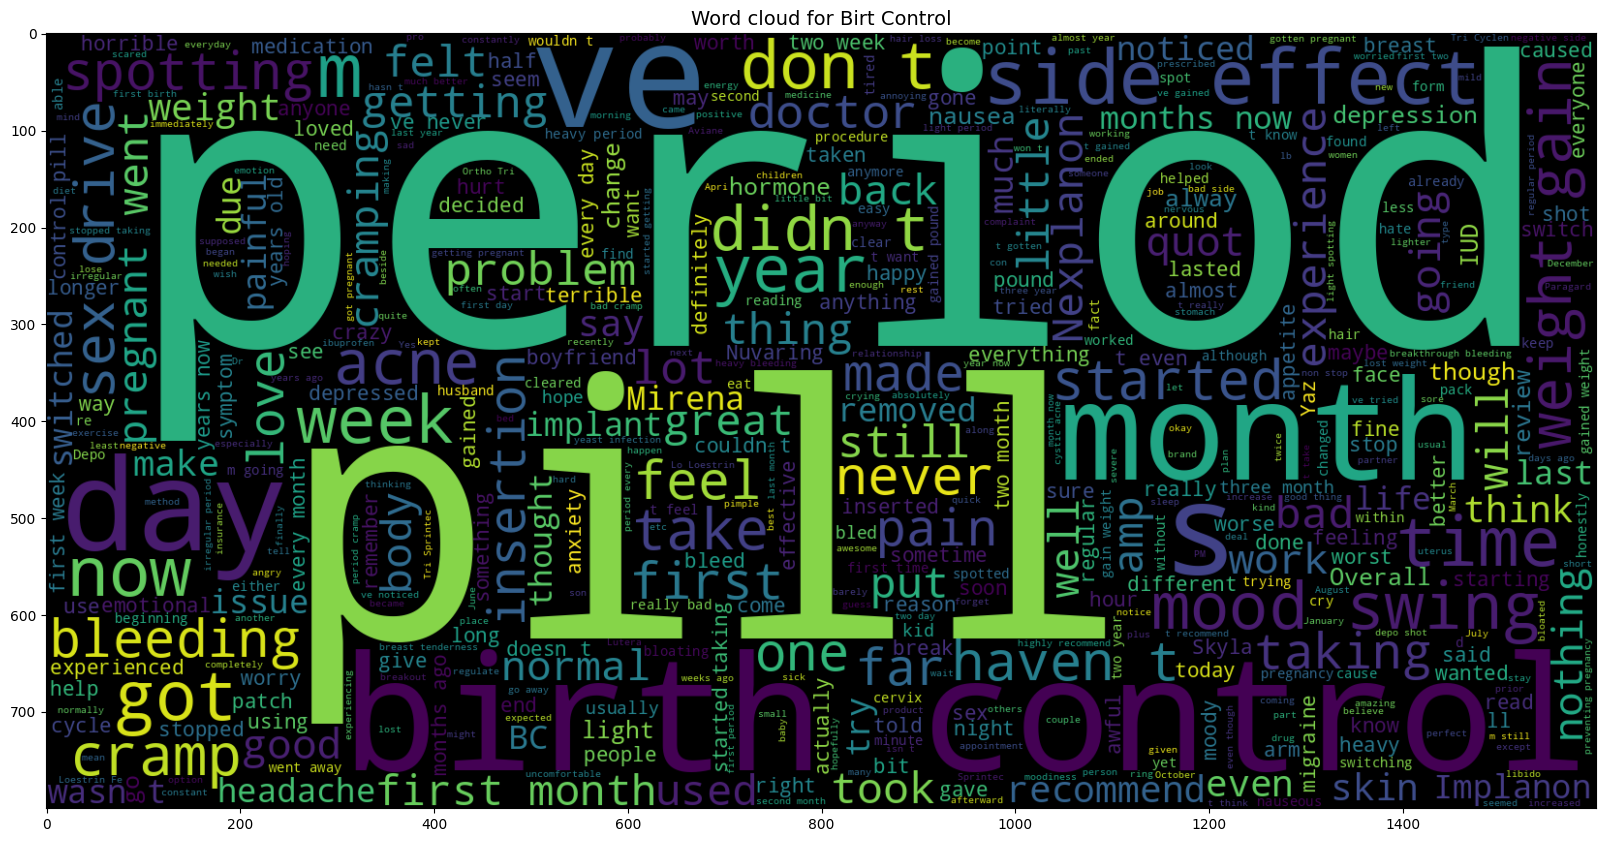

In [66]:
from wordcloud import WordCloud
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(' '.join(X_birth.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Birt Control', fontsize = 14)

Text(0.5, 1.0, 'Word cloud for Depression')

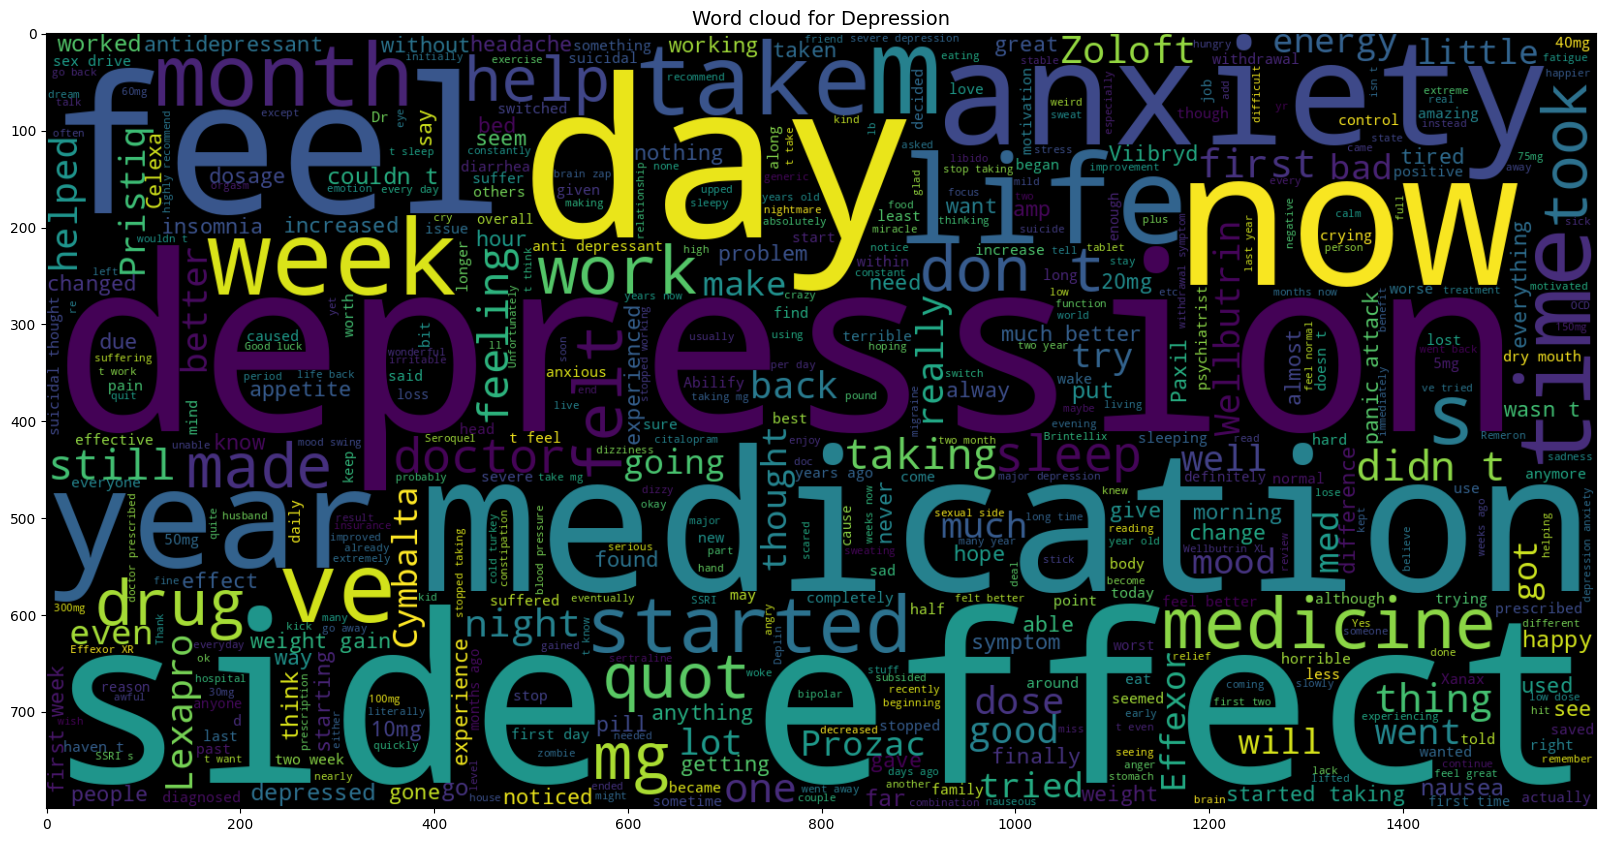

In [67]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(' '.join(X_depression.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Depression', fontsize = 14)

Text(0.5, 1.0, 'Word cloud for Hight Blood Pressure')

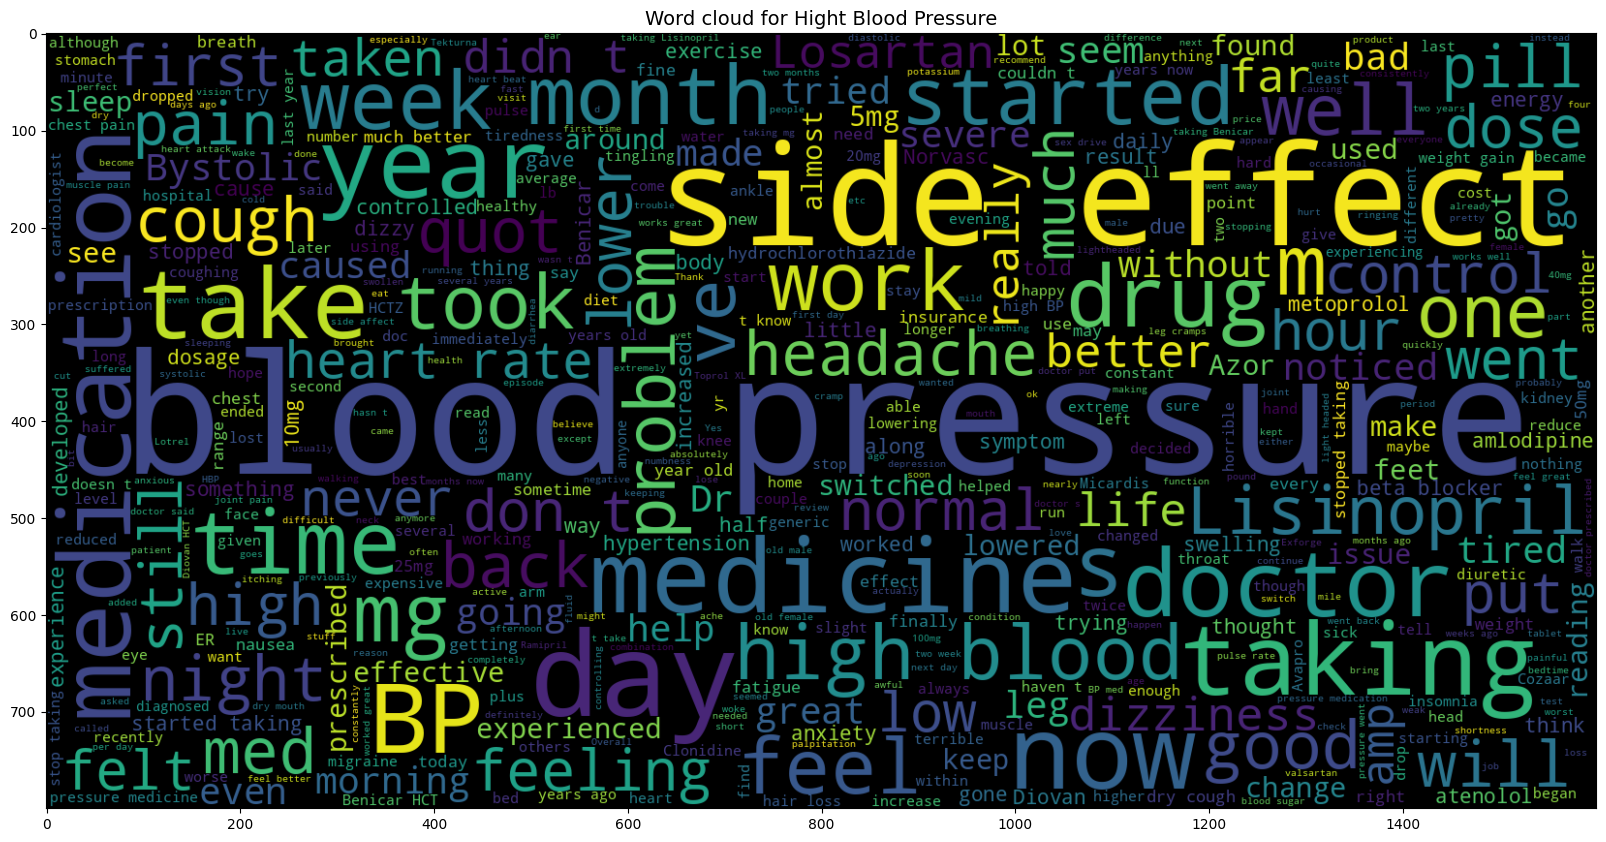

In [68]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(' '.join(X_highBloodPressure.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Hight Blood Pressure', fontsize = 14)

Text(0.5, 1.0, 'Word cloud for Diabetes')

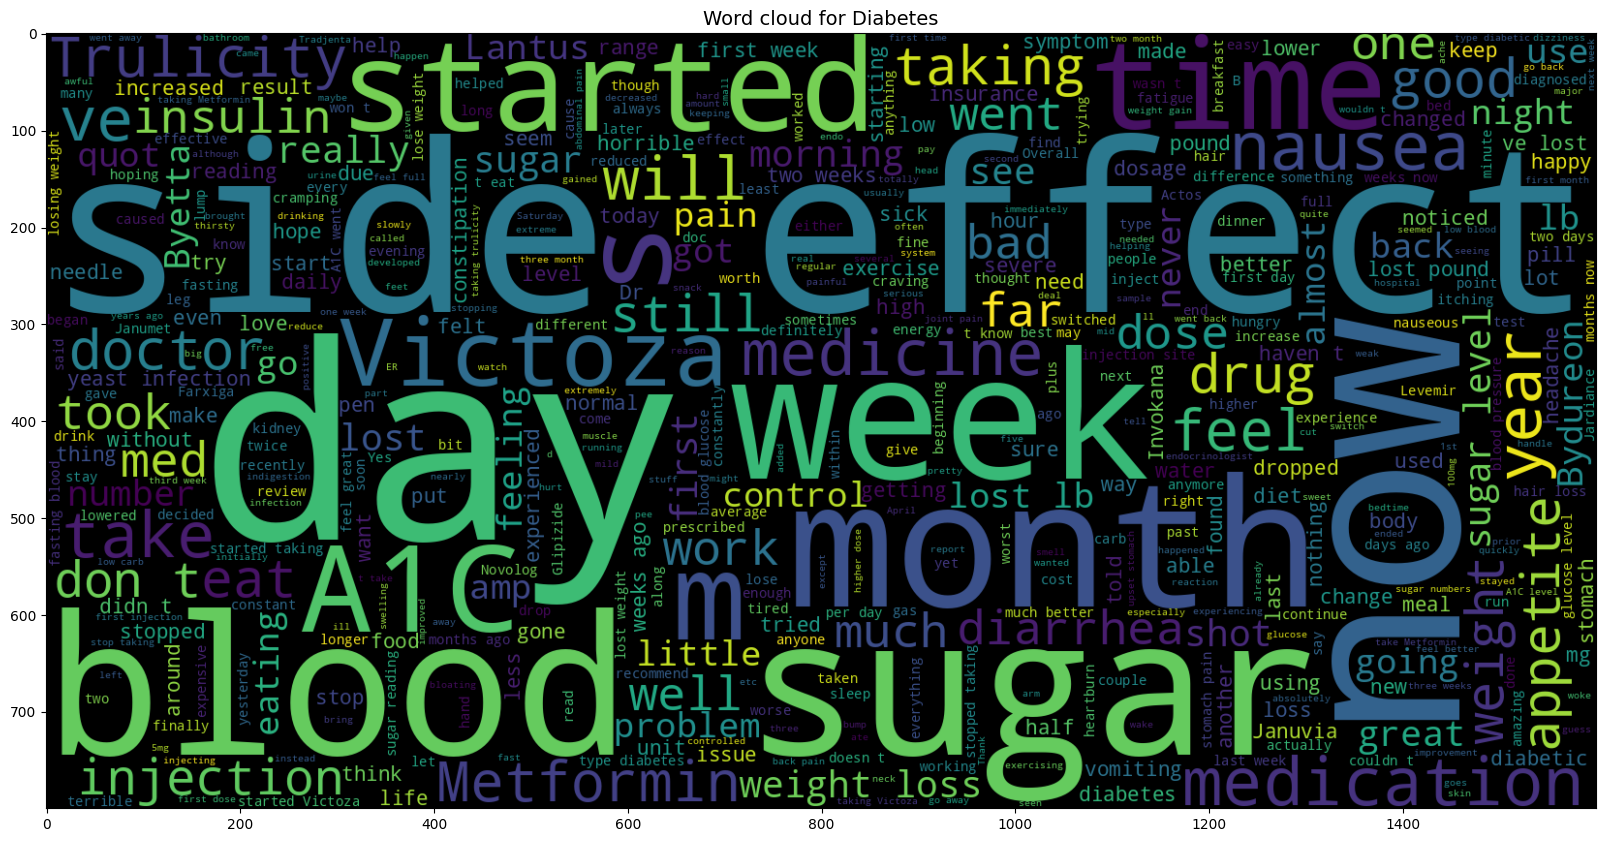

In [69]:
plt.figure(figsize = (20, 20))
wc = WordCloud(max_words = 500, width = 1600, height = 800).generate(' '.join(X_diabetes.review))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word cloud for Diabetes', fontsize = 14)

### Data Preprocessing

In [70]:
X_df['review'][3]

'"This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch"'

In [71]:
# removing quotation
for i, col in enumerate(X_df.columns) :
  X_df.iloc[:, i] = X_df.iloc[:, i].str.replace('"', '')

In [72]:
X_df['review'][3]

'This is my first time using any form of birth control. I&#039;m glad I went with the patch, I have been on it for 8 months. At first It decreased my libido but that subsided. The only downside is that it made my periods longer (5-6 days to be exact) I used to only have periods for 3-4 days max also made my cramps intense for the first two days of my period, I never had cramps before using birth control. Other than that in happy with the patch'

In [73]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [74]:
# Remove the stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [75]:
stop[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [76]:
# lemmatization
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

porter = PorterStemmer()
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [77]:
print(porter.stem("Surprisingly"))
print(porter.stem("Very"))
print(porter.stem('Excited'))

surprisingli
veri
excit


In [78]:
print(lemmatizer.lemmatize("Surprisingly"))
print(lemmatizer.lemmatize("Very"))
print(lemmatizer.lemmatize("Excited"))

Surprisingly
Very
Excited


In [79]:
# to remove html, link, handler and special characters
from bs4 import BeautifulSoup
import re

In [80]:
def review_to_words(raw_review) :
  # delete html
  review_txt = BeautifulSoup(raw_review, 'html.parser').get_text()
  # make a space
  letters_only = re.sub('[^a-zA-Z]', ' ', review_txt)
  # lowercasing the letters
  words = letters_only.lower().split()
  # stopword removing
  meaningful_words = [w for w in words if not w in stop]
  # lemmatization
  lemmatize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
  # space join words
  return (' '.join(lemmatize_words))

In [81]:
X_df['review_clean'] = X_df['review'].apply(review_to_words)

<ipython-input-80-af2ba9b0252f>:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_txt = BeautifulSoup(raw_review, 'html.parser').get_text()


In [82]:
X_df.head()

condition                                             review  \
2   Birth Control  I used to take another oral contraceptive, whi...   
3   Birth Control  This is my first time using any form of birth ...   
9   Birth Control  I had been on the pill for many years. When my...   
11     Depression  I have taken anti-depressants for years, with ...   
14  Birth Control  Started Nexplanon 2 months ago because I have ...   

                                         review_clean  
2   used take another oral contraceptive pill cycl...  
3   first time using form birth control glad went ...  
9   pill many year doctor changed rx chateal effec...  
11  taken anti depressant year improvement mostly ...  
14  started nexplanon month ago minimal amount con...

In [83]:
# creating feature and target columns
x_feature = X_df['review_clean']
y = X_df['condition']

In [99]:
pip install -U scikit-learn

In [100]:
x_train, x_test, y_train, y_test = train_test_split(x_feature, y, stratify=y, test_size=0.2, random_state=2)

In [101]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Bag of Words

In [102]:
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(x_train)
count_test = count_vectorizer.transform(x_test)

## Machine Learning Model : Naive Bayes

Accuracy : 0.972
Confusion matrix, without normalization


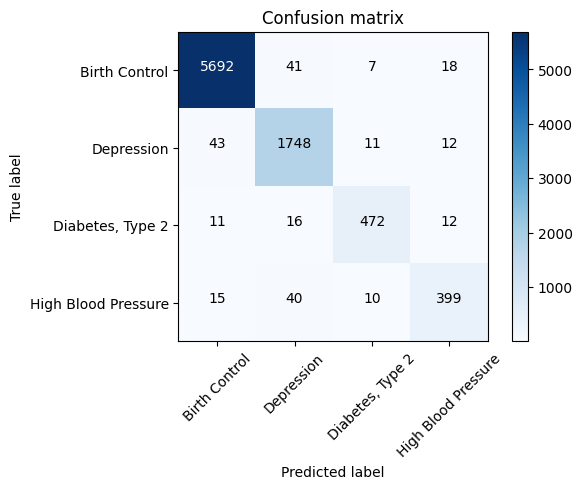

In [103]:
naive_bayes = MultinomialNB()
naive_bayes.fit(count_train, y_train)
pred = naive_bayes.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### Machine Learning Model : Passive Aggressive Classifier

Accuracy : 0.977
Confusion matrix, without normalization


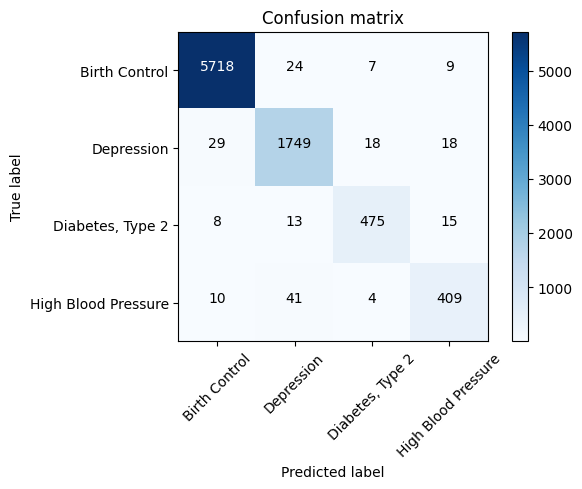

In [104]:
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression

passive_cls = PassiveAggressiveClassifier()
passive_cls.fit(count_train, y_train)
pred = passive_cls.predict(count_test)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### Using TFIDF

In [144]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vec = TfidfVectorizer(stop_words = 'english', max_df=0.8)
tfidf_train = tfidf_vec.fit_transform(x_train)
tfidf_test = tfidf_vec.transform(x_test)

## Machine Learning Model : Naive Bayes

Accuracy : 0.921
Confusion matrix, without normalization


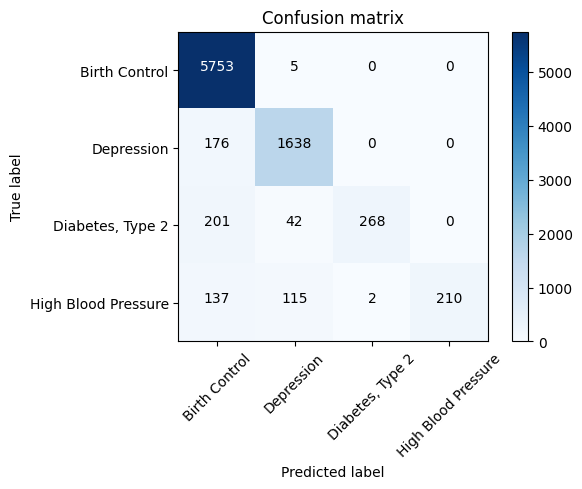

In [145]:
mnb_tf = MultinomialNB()
mnb_tf.fit(tfidf_train, y_train)
pred = mnb_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

## Machine Learning Model : Passive Aggressive Classifier

Accuracy : 0.982
Confusion matrix, without normalization


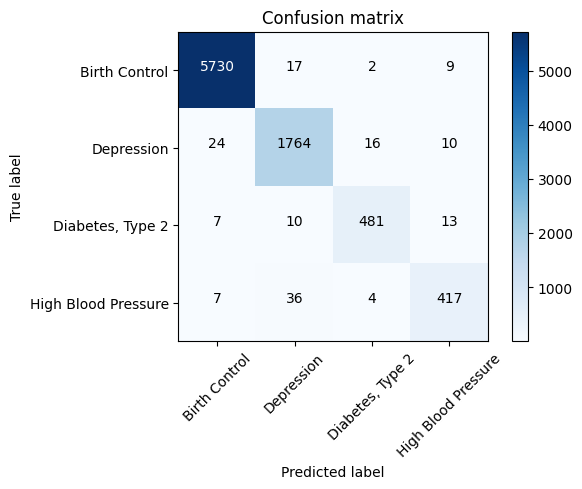

In [146]:
passive_tfidf = PassiveAggressiveClassifier()
passive_tfidf.fit(tfidf_train, y_train)
pred = passive_tfidf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### Using TFIDF : Bigrams and Passive Aggressive Classifier

> Add blockquote



In [147]:
tfidf_vec2 = TfidfVectorizer(stop_words = 'english', max_df=0.8, ngram_range=(1, 2))
tfidf_train2 = tfidf_vec2.fit_transform(x_train)
tfidf_test2 = tfidf_vec2.transform(x_test)

Accuracy : 0.986
Confusion matrix, without normalization


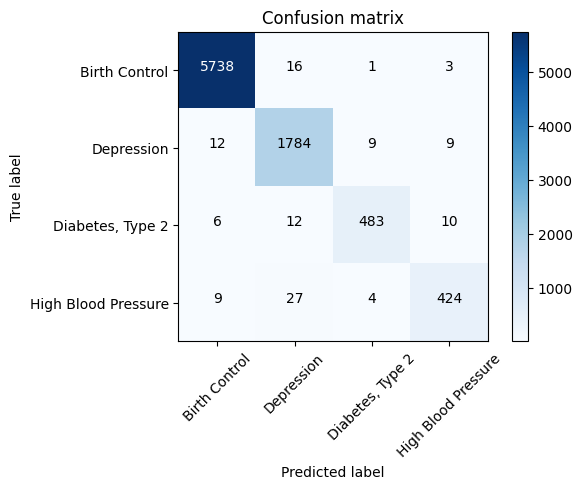

In [148]:
passive_tfidf2 = PassiveAggressiveClassifier()
passive_tfidf2.fit(tfidf_train2, y_train)
pred = passive_tfidf2.predict(tfidf_test2)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### Using TFIDF : Trigram and Passive Aggressive Classifier

In [149]:
tfidf_vec3 = TfidfVectorizer(stop_words = 'english', max_df=0.8, ngram_range=(1, 3))
tfidf_train3 = tfidf_vec3.fit_transform(x_train)
tfidf_test3 = tfidf_vec3.transform(x_test)

In [150]:
tfidf_test3

<8547x1083646 sparse matrix of type '<class 'numpy.float64'>'
	with 729368 stored elements in Compressed Sparse Row format>

Accuracy : 0.984
Confusion matrix, without normalization


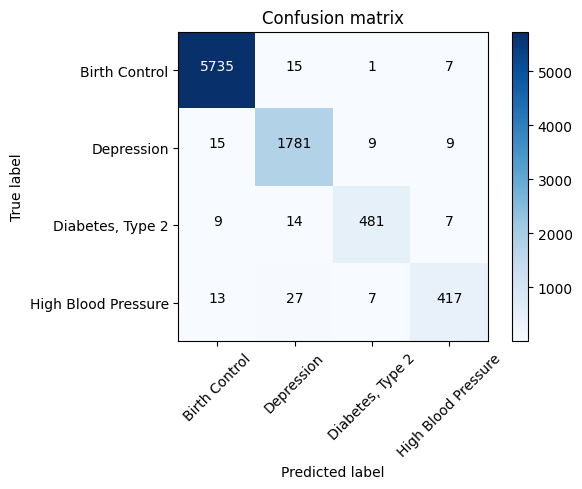

In [151]:
passive_tfidf3 = PassiveAggressiveClassifier()
passive_tfidf3.fit(tfidf_train3, y_train)
pred = passive_tfidf3.predict(tfidf_test3)
score = metrics.accuracy_score(y_test, pred)

print("Accuracy : %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])
plot_confusion_matrix(cm, classes=['Birth Control', 'Depression','Diabetes, Type 2','High Blood Pressure'])

### Important Features

In [152]:
X_df.tail()

condition  \
161273        Birth Control   
161278     Diabetes, Type 2   
161286           Depression   
161290  High Blood Pressure   
161291        Birth Control   

                                                   review  \
161273  I have had the Nexplanon since Dec. 27, 2016 \...   
161278  I just got diagnosed with type 2. My doctor pr...   
161286  This is the third med I&#039;ve tried for anxi...   
161290  I have only been on Tekturna for 9 days. The e...   
161291  This would be my second month on Junel. I&#039...   

                                             review_clean  
161273  nexplanon since dec got first period end janua...  
161278  got diagnosed type doctor prescribed invokana ...  
161286  third med tried anxiety mild depression week h...  
161290  tekturna day effect immediate also calcium cha...  
161291  would second month junel birth control year ch...

In [153]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names_out()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)

In [155]:
most_informative_feature_for_class(tfidf_vec2, passive_tfidf2, 'Birth Control')

Birth Control insertion 4.431151474727152
Birth Control cramp 4.621423862243462
Birth Control spotting 4.732990521183862
Birth Control pregnant 5.232371961557375
Birth Control bleeding 5.237994412741483
Birth Control birth control 5.762039576105072
Birth Control birth 6.074865133118922
Birth Control acne 6.316175420581968
Birth Control pill 7.221250250006017
Birth Control period 9.923429508125105


In [156]:
most_informative_feature_for_class(tfidf_vec2, passive_tfidf2, 'Depression')

Depression antidepressant 4.74972827621404
Depression viibryd 4.798679871783905
Depression prozac 5.12782900064967
Depression cymbalta 5.134772943580947
Depression effexor 5.1842916111309485
Depression lexapro 6.022358504019949
Depression zoloft 6.098083626073293
Depression wellbutrin 6.272816920552151
Depression pristiq 6.3313559815771505
Depression depression 6.604774795324238


In [157]:
most_informative_feature_for_class(tfidf_vec2, passive_tfidf2, 'High Blood Pressure')

High Blood Pressure blood pressure 3.238957373915377
High Blood Pressure metoprolol 3.4655890540161645
High Blood Pressure amlodipine 3.7204663112155187
High Blood Pressure bystolic 3.7380246038186535
High Blood Pressure benicar 3.8403670979530804
High Blood Pressure losartan 4.426078509382038
High Blood Pressure cough 4.535923903547538
High Blood Pressure lisinopril 5.585424579842058
High Blood Pressure pressure 5.7168505719046445
High Blood Pressure bp 7.411110765003791


In [164]:
most_informative_feature_for_class(tfidf_vec2, passive_tfidf2, 'Diabetes, Type 2')

Diabetes, Type 2 diabetes 3.99973868491643
Diabetes, Type 2 januvia 4.142540823206787
Diabetes, Type 2 byetta 4.175451474455885
Diabetes, Type 2 insulin 4.2588739737049695
Diabetes, Type 2 injection 4.725946893290184
Diabetes, Type 2 invokana 5.076635173108346
Diabetes, Type 2 trulicity 5.712384520653112
Diabetes, Type 2 victoza 6.685620433359714
Diabetes, Type 2 sugar 7.0739592286213595
Diabetes, Type 2 metformin 7.597306319743868


In [168]:
## Function for Extracting Top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

In [170]:
text = ['I just got diagnosed with type 2. My doctor prescribed Invokana and metformin from the beginning. My sugars went down to normal by the second week. I am losing so much weight. No side effects yet. Miracle medicine for me']
test = tfidf_vec2.transform(text)
pred1 = passive_tfidf2.predict(test)[0]
print(f'Predicted Patient Condition {pred1}. Suggested Medications are -')
for drug in top_drugs_extractor(pred1) :
  print(drug)

Predicted Patient Condition Diabetes, Type 2. Suggested Medications are -
Victoza
Canagliflozin
Invokana


In [171]:
text2 = ['This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.']
test2 = tfidf_vec2.transform(text2)
pred2 = passive_tfidf2.predict(test2)[0]
print(f'Predicted Patient Condition {pred2}. Suggested Medications are -')
for drug in top_drugs_extractor(pred2) :
  print(drug)

Predicted Patient Condition Depression. Suggested Medications are -
Sertraline
Zoloft
Viibryd
